# Problema 2 - Utilizar RNN e LSTM para prever se uma critica é positiva ou negativa

In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
Num CPUs Available:  1
TensorFlow version: 2.20.0


In [1]:
import pandas as pd

df = pd.read_csv('./dataset/rotten_tomatoes_movie_reviews.csv')

In [2]:
df.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


In [3]:
df.info()


print("\nValores únicos em scoreSentiment:")
count_values = df['scoreSentiment'].value_counts()
percentages = df['scoreSentiment'].value_counts(normalize=True) * 100


pd.DataFrame({
    'Count': count_values,
    'Percentage': percentages.round(2).astype(str) + '%'
})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444963 entries, 0 to 1444962
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1444963 non-null  object
 1   reviewId        1444963 non-null  int64 
 2   creationDate    1444963 non-null  object
 3   criticName      1444963 non-null  object
 4   isTopCritic     1444963 non-null  bool  
 5   originalScore   1009745 non-null  object
 6   reviewState     1444963 non-null  object
 7   publicatioName  1444963 non-null  object
 8   reviewText      1375738 non-null  object
 9   scoreSentiment  1444963 non-null  object
 10  reviewUrl       1234038 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 111.6+ MB

Valores únicos em scoreSentiment:


,Count,Percentage
scoreSentiment,,
POSITIVE,963799,66.7%
NEGATIVE,481164,33.3%


In [4]:
df['scoreSentimentBinary'] = df['scoreSentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})

df[['scoreSentiment', 'scoreSentimentBinary']].head()

,scoreSentiment,scoreSentimentBinary
0,POSITIVE,1
1,NEGATIVE,0
2,POSITIVE,1
3,NEGATIVE,0
4,POSITIVE,1


In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['reviewText'], inplace=True)
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

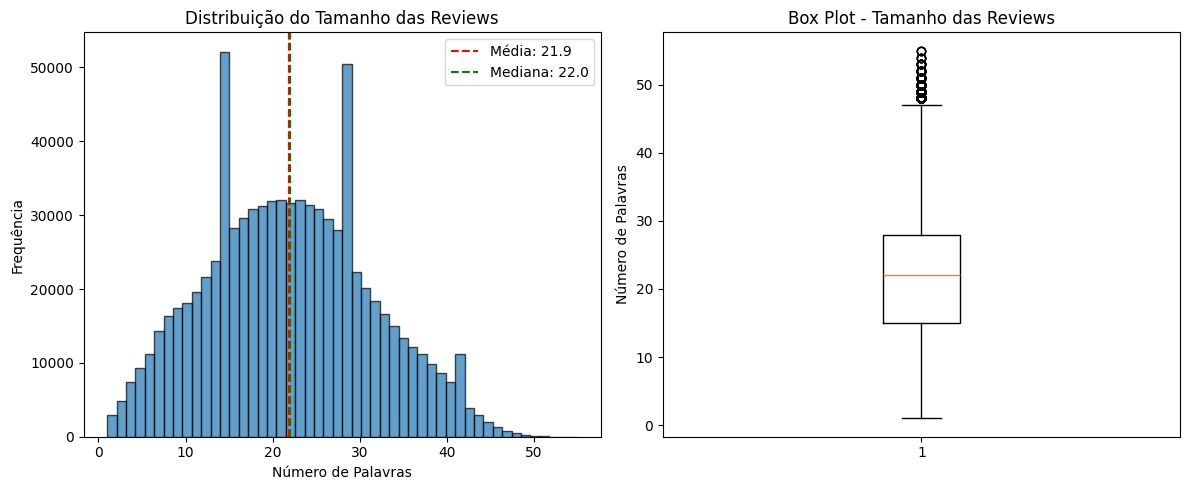

=== ESTATÍSTICAS DO TAMANHO DAS REVIEWS ===
Mínimo: 1 palavras
Máximo: 55 palavras
Média: 21.92 palavras
Mediana: 22.00 palavras
Desvio padrão: 9.45

=== PERCENTIS ===
25º percentil: 15 palavras (cobre 26.9% dos dados)
50º percentil: 22 palavras (cobre 53.3% dos dados)
75º percentil: 28 palavras (cobre 75.2% dos dados)
80º percentil: 30 palavras (cobre 80.9% dos dados)
90º percentil: 35 palavras (cobre 91.1% dos dados)
95º percentil: 38 palavras (cobre 95.2% dos dados)
99º percentil: 43 palavras (cobre 99.0% dos dados)


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Analisar distribuição de tamanhos das reviews
review_lengths = df['word_count']

plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
plt.hist(review_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do Tamanho das Reviews')
plt.axvline(review_lengths.mean(), color='red', linestyle='--', label=f'Média: {review_lengths.mean():.1f}')
plt.axvline(review_lengths.median(), color='green', linestyle='--', label=f'Mediana: {review_lengths.median():.1f}')
plt.legend()

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(review_lengths)
plt.ylabel('Número de Palavras')
plt.title('Box Plot - Tamanho das Reviews')

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("=== ESTATÍSTICAS DO TAMANHO DAS REVIEWS ===")
print(f"Mínimo: {review_lengths.min()} palavras")
print(f"Máximo: {review_lengths.max()} palavras")
print(f"Média: {review_lengths.mean():.2f} palavras")
print(f"Mediana: {review_lengths.median():.2f} palavras")
print(f"Desvio padrão: {review_lengths.std():.2f}")

# Percentis importantes
percentiles = [25, 50, 75, 80, 90, 95, 99]
print("\n=== PERCENTIS ===")
for p in percentiles:
    value = np.percentile(review_lengths, p)
    percentage_covered = (review_lengths <= value).mean() * 100
    print(f"{p}º percentil: {value:.0f} palavras (cobre {percentage_covered:.1f}% dos dados)")

In [7]:
from sklearn.model_selection import train_test_split

x = df['reviewText']
y = df['scoreSentimentBinary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {len(x_train)}")
print(f"Tamanho do conjunto de teste: {len(x_test)}")

Tamanho do conjunto de treino: 652159
Tamanho do conjunto de teste: 163040


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional
import numpy as np

# Definir parâmetros
max_words = 10000  # Tamanho máximo do vocabulário
max_len = 43  # Comprimento máximo da sequência

# Criar e treinar o tokenizador
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

# Converter textos em sequências
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Preencher sequências para garantir comprimento uniforme
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')

# Verificar a forma dos nossos dados
print(f"Training data shape: {x_train_pad.shape}")
print(f"Testing data shape: {x_test_pad.shape}")

Training data shape: (652159, 43)
Testing data shape: (163040, 43)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configurar callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Métrica a monitorar
    patience=3,                  # Aguardar 3 épocas sem melhoria
    restore_best_weights=True,   # Restaurar os melhores pesos
    verbose=1                    # Mostrar quando parar
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Métrica a monitorar
    factor=0.5,                  # Reduzir LR pela metade
    patience=2,                  # Aguardar 2 épocas sem melhoria
    min_lr=1e-6,                 # LR mínimo
    verbose=1
)

# Opcional: Salvar o melhor modelo
checkpoint = ModelCheckpoint(
    'best_model.h5',             # Nome do arquivo
    monitor='val_accuracy',      # Métrica a monitorar
    save_best_only=True,         # Salvar apenas o melhor
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [11]:
from tensorflow.keras.layers import SimpleRNN


# Construir modelo RNN para análise de sentimento
model = Sequential([
    # Camada de Embedding para converter tokens em vetores de tamanho fixo
    Embedding(input_dim=max_words, output_dim=64),
    
    # Camada SimpleRNN 
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    
    # Camada de saída com ativação sigmoid para classificação binária
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train_pad, y_train, epochs=50, batch_size=64, validation_data=(x_test_pad, y_test), callbacks=callbacks)
model.summary()

Epoch 1/50


I0000 00:00:1759612191.680421   40452 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5006 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9
2025-10-04 18:09:52.898043: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f2afc0080e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-04 18:09:52.898057: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-10-04 18:09:52.922564: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-04 18:09:53.054496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-04 18:09:53.135486: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All confi

   48/10190 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5923 - loss: 0.6861  

I0000 00:00:1759612195.340306   41063 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10185/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.6395

2025-10-04 18:10:27.195801: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 18:10:27.195823: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 18:10:27.195834: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 18:10:27.195844: I external/l

10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6676 - loss: 0.6395

2025-10-04 18:10:29.592348: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 18:10:30.064905: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 360 bytes spill stores, 360 bytes spill loads

2025-10-04 18:10:32.718101: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-04 18:10:33.143411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :


Epoch 1: val_accuracy improved from None to 0.66978, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6688 - loss: 0.6374 - val_accuracy: 0.6698 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 2/50
10177/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6696 - loss: 0.6360
Epoch 2: val_accuracy improved from 0.66978 to 0.66980, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6697 - loss: 0.6358 - val_accuracy: 0.6698 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 3/50
10183/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6703 - loss: 0.6351
Epoch 3: val_accuracy did not improve from 0.66980
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6698 - loss: 0.6355 - val_accuracy: 0.6697 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 4/50
10175/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6694 - loss: 0.6357
Epoch 4: val_accuracy did not improve from 0.66980
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.6700 - loss: 0.6357 - val_accuracy: 0.6698 - val_loss: 0.6343 - learning_rate: 0.0010
Epoch 5/50
10176/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6698 - loss: 0.6354
Epoch 5: val_accuracy did not improve from 0.66980
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.6701 - loss: 0.6352 - val_accuracy: 0.6693 - val_loss: 0.6344 - learning_rate: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 43, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,501 (7.61 MB)

 Trainable params: 664,833 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,329,668 (5.07 MB)

5095/5095 ━━━━━━━━━━━━━━━━━━━━ 5s 953us/step - accuracy: 0.6693 - loss: 0.6335
Perda de Teste: 0.6335
Precisão de Teste: 0.6693


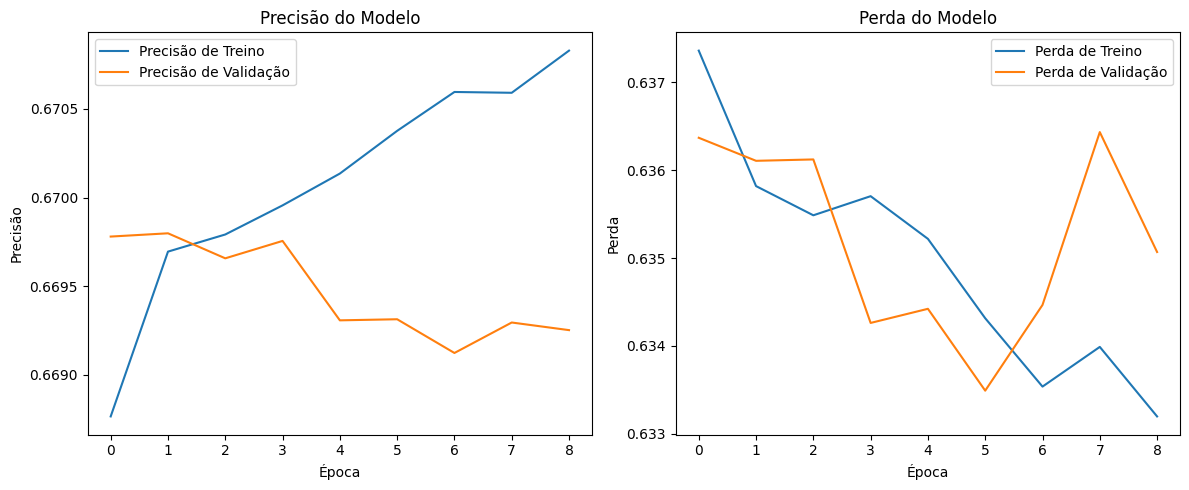


Testando modelo com exemplos de críticas:
Crítica: 'This movie was great!'
Previsto: POSITIVO (probabilidade: 0.6950, confiança: 0.6950)
---
Crítica: 'Absolutely loved it'
Previsto: POSITIVO (probabilidade: 0.6950, confiança: 0.6950)
---
Crítica: 'Terrible film, waste of time'
Previsto: POSITIVO (probabilidade: 0.6463, confiança: 0.6463)
---
Crítica: 'Boring and predictable'
Previsto: POSITIVO (probabilidade: 0.6463, confiança: 0.6463)
---


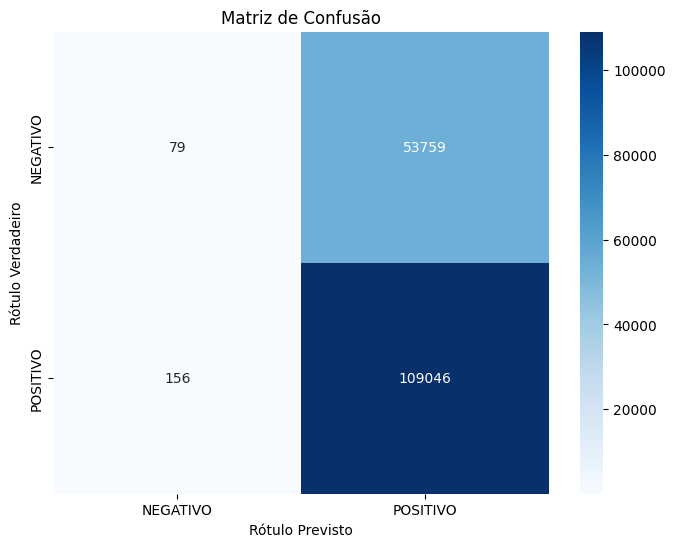


Relatório de Classificação:
              precision    recall  f1-score   support

    NEGATIVO       0.34      0.00      0.00     53838
    POSITIVO       0.67      1.00      0.80    109202

    accuracy                           0.67    163040
   macro avg       0.50      0.50      0.40    163040
weighted avg       0.56      0.67      0.54    163040



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Avaliar desempenho do modelo
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=1)
print(f"Perda de Teste: {loss:.4f}")
print(f"Precisão de Teste: {accuracy:.4f}")

# Plotar curvas de aprendizado
import matplotlib.pyplot as plt

# Verificar se o histórico do modelo está disponível e plotar curvas de aprendizado
if hasattr(model, 'history') and model.history.history:
    history = model.history.history
    
    plt.figure(figsize=(12, 5))
    
    # Plotar precisão
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Precisão de Treino')
    plt.plot(history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()
    
    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Perda de Treino')
    plt.plot(history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Histórico de treinamento não encontrado.")

# Função para prever sentimento para novas críticas
def predict_sentiment(text):
    # Tokenizar e preencher o texto
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Fazer previsão
    prediction = model.predict(padded_sequence, verbose=0)[0][0]
    
    # Interpretar resultado
    sentiment = "POSITIVO" if prediction > 0.5 else "NEGATIVO"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return sentiment, prediction, confidence

# Testar com exemplos de críticas
example_reviews = [
    "This movie was great!",
    "Absolutely loved it",
    "Terrible film, waste of time",
    "Boring and predictable"
]

print("\nTestando modelo com exemplos de críticas:")
for review in example_reviews:
    sentiment, prob, conf = predict_sentiment(review)
    print(f"Crítica: '{review}'")
    print(f"Previsto: {sentiment} (probabilidade: {prob:.4f}, confiança: {conf:.4f})")
    print("---")

# Criar matriz de confusão
y_pred_prob = model.predict(x_test_pad, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEGATIVO', 'POSITIVO'], yticklabels=['NEGATIVO', 'POSITIVO'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NEGATIVO', 'POSITIVO']))


# Teste com LSTM

In [13]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model_lstm.fit(x_train_pad, y_train, epochs=50, batch_size=64, validation_data=(x_test_pad, y_test), callbacks=callbacks)
model_lstm.summary()

Epoch 1/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7307 - loss: 0.5373
Epoch 1: val_accuracy improved from 0.66980 to 0.83870, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 567s 55ms/step - accuracy: 0.7859 - loss: 0.4461 - val_accuracy: 0.8387 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 2/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8467 - loss: 0.3413
Epoch 2: val_accuracy improved from 0.83870 to 0.84991, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 566s 56ms/step - accuracy: 0.8478 - loss: 0.3393 - val_accuracy: 0.8499 - val_loss: 0.3365 - learning_rate: 0.0010
Epoch 3/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8611 - loss: 0.3140
Epoch 3: val_accuracy improved from 0.84991 to 0.85252, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 564s 55ms/step - accuracy: 0.8594 - loss: 0.3171 - val_accuracy: 0.8525 - val_loss: 0.3297 - learning_rate: 0.0010
Epoch 4/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8696 - loss: 0.2971
Epoch 4: val_accuracy improved from 0.85252 to 0.85395, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 565s 55ms/step - accuracy: 0.8673 - loss: 0.3016 - val_accuracy: 0.8539 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 5/50
10189/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8759 - loss: 0.2848
Epoch 5: val_accuracy improved from 0.85395 to 0.85445, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 567s 56ms/step - accuracy: 0.8737 - loss: 0.2892 - val_accuracy: 0.8544 - val_loss: 0.3290 - learning_rate: 0.0010
Epoch 6/50
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8832 - loss: 0.2719
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy improved from 0.85445 to 0.85504, saving model to best_model.h5


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 564s 55ms/step - accuracy: 0.8801 - loss: 0.2773 - val_accuracy: 0.8550 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 7/50
10189/10190 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8919 - loss: 0.2538
Epoch 7: val_accuracy did not improve from 0.85504
10190/10190 ━━━━━━━━━━━━━━━━━━━━ 564s 55ms/step - accuracy: 0.8909 - loss: 0.2560 - val_accuracy: 0.8542 - val_loss: 0.3437 - learning_rate: 5.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 43, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,216,837 (8.46 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,477,892 (5.64 MB)

5095/5095 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.8539 - loss: 0.3276
Perda de Teste: 0.3276
Precisão de Teste: 0.8539


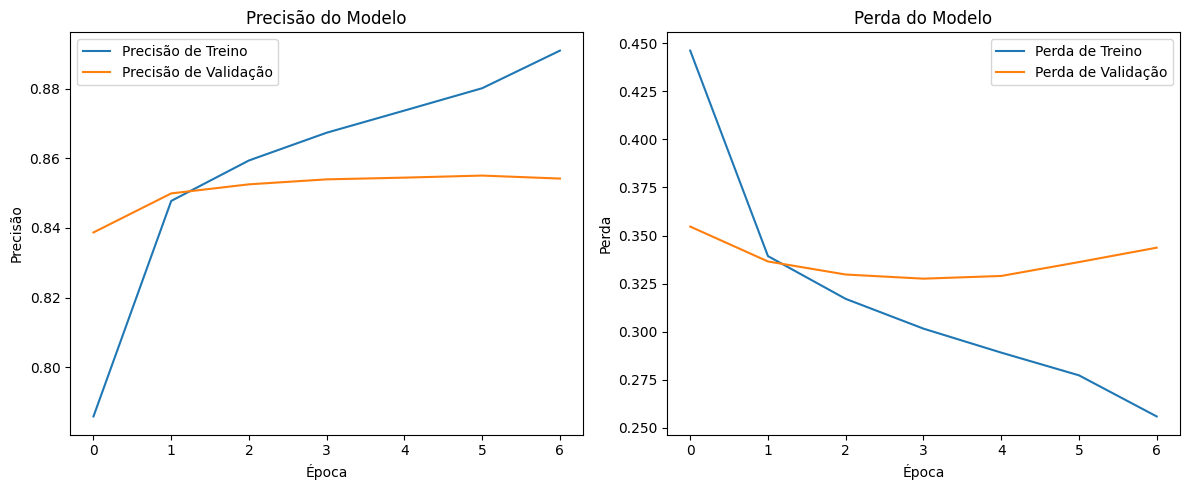


Testando modelo com exemplos de críticas:
Crítica: 'This movie was great!'
Previsto: POSITIVO (probabilidade: 0.7753, confiança: 0.7753)
---
Crítica: 'Absolutely loved it'
Previsto: POSITIVO (probabilidade: 0.9932, confiança: 0.9932)
---
Crítica: 'Terrible film, waste of time'
Previsto: NEGATIVO (probabilidade: 0.0138, confiança: 0.9862)
---
Crítica: 'Boring and predictable'
Previsto: NEGATIVO (probabilidade: 0.0166, confiança: 0.9834)
---


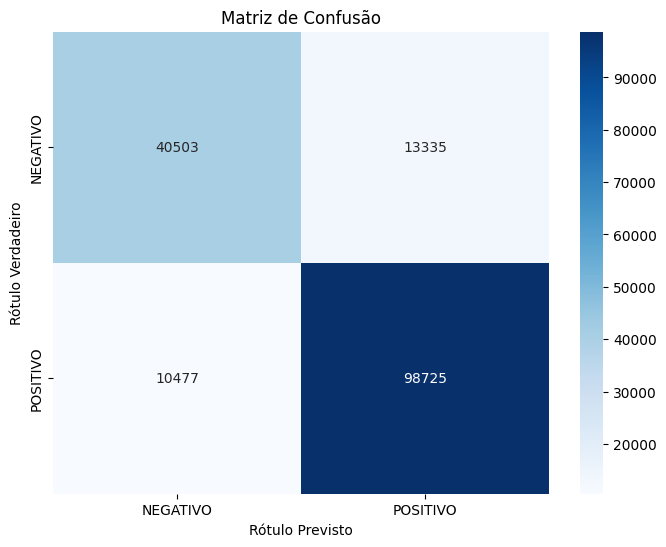


Relatório de Classificação:
              precision    recall  f1-score   support

    NEGATIVO       0.79      0.75      0.77     53838
    POSITIVO       0.88      0.90      0.89    109202

    accuracy                           0.85    163040
   macro avg       0.84      0.83      0.83    163040
weighted avg       0.85      0.85      0.85    163040



In [14]:
# Avaliar desempenho do modelo
loss, accuracy = model_lstm.evaluate(x_test_pad, y_test, verbose=1)
print(f"Perda de Teste: {loss:.4f}")
print(f"Precisão de Teste: {accuracy:.4f}")

# Verificar se o histórico do modelo está disponível e plotar curvas de aprendizado
if hasattr(model_lstm, 'history') and model_lstm.history.history:
    history = model_lstm.history.history

    plt.figure(figsize=(12, 5))
    
    # Plotar precisão
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Precisão de Treino')
    plt.plot(history['val_accuracy'], label='Precisão de Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()
    
    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Perda de Treino')
    plt.plot(history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Histórico de treinamento não encontrado.")

# Função para prever sentimento para novas críticas
def predict_sentiment(text):
    # Tokenizar e preencher o texto
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
    # Fazer previsão
    prediction = model_lstm.predict(padded_sequence, verbose=0)[0][0]

    # Interpretar resultado
    sentiment = "POSITIVO" if prediction > 0.5 else "NEGATIVO"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return sentiment, prediction, confidence

# Testar com exemplos de críticas
example_reviews = [
    "This movie was great!",
    "Absolutely loved it",
    "Terrible film, waste of time",
    "Boring and predictable"
]

print("\nTestando modelo com exemplos de críticas:")
for review in example_reviews:
    sentiment, prob, conf = predict_sentiment(review)
    print(f"Crítica: '{review}'")
    print(f"Previsto: {sentiment} (probabilidade: {prob:.4f}, confiança: {conf:.4f})")
    print("---")

# Criar matriz de confusão
y_pred_prob = model_lstm.predict(x_test_pad, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['NEGATIVO', 'POSITIVO'], yticklabels=['NEGATIVO', 'POSITIVO'])
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NEGATIVO', 'POSITIVO']))
